In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class KacRing():
  """Kac ring object, useful to show the transition from time-reversible &
  recurrent classical mechanics to irreversible and non-recurrent statistical
  mechanics.

    Attributes
    ----------
    meta : dict
        the meta-data of the Kac Ring (see below)
    sites : numpy 1D array
        the array of sites in the ring (1 means black and -1 means white)
    markers : numpy 1D array
        the array of markers in the ring, with the edges going from the ith 
        element (1 means no-marker and -1 means marker)
    
    Attributes of meta
    ----------
    n_black : int
        the number of black sites
    n_white : int
        the number of white sites
    delta : int
        the difference n_black - n_white
    mu : float
        the probability of a marker at an edge

    Methods
    -------
    step(clockwise=True)
        Rotates the ring 1 site in the direction specified

  """
  def __init__(self, n_black, n_white, mu, rng_site_seed=42):
    self.meta = {'n_black': n_black, 'n_white': n_white, 
                 'n_sites': n_black+n_white, 'delta': n_black-n_white, 'mu': mu}

    rng_site = np.random.default_rng(seed=rng_site_seed)
    rng_marker = np.random.default_rng(seed=None)

    unshuffled_sites = np.array([1 for i in range(n_black)] 
                                + [-1 for i in range(n_white)])
    self.sites = rng_site.permutation(unshuffled_sites)
    self.markers = rng_marker.choice([-1, 1], p=[mu, 1-mu], 
                                     size=self.meta['n_sites'])

  def step(self, clockwise=True):
    """Performs a rotation of the sites around the ring, keeping the markers
    'in-place'. Then updates the delta with the new sites array.

      Parameters
      -------
      clockwise=True : Boolean
          the direction of the step (clockwise or counter-clockwise)

    """
    if clockwise:
      self.sites = self.sites * self.markers
      self.sites = np.roll(self.sites, 1)

      self.meta['delta'] = np.sum(self.sites)
      self.meta['n_black'] = (self.meta['n_sites'] + self.meta['delta'])//2
      self.meta['n_white'] = (self.meta['n_sites'] - self.meta['delta'])//2
    else:
      self.sites[0] = self.sites[0] * self.markers[-1]
      self.sites[1:] = self.sites[1:] * self.markers[:-1]
      self.sites = np.roll(self.sites, -1)

      self.meta['delta'] = np.sum(self.sites)
      self.meta['n_black'] = (self.meta['n_sites'] + self.meta['delta'])//2
      self.meta['n_white'] = (self.meta['n_sites'] - self.meta['delta'])//2

  def stat_delta(self, n_steps, clockwise=True):
    """Calculates the statistical equations calculation of delta for a given 
    number of steps.

      Parameters
      -------
      n_steps : int >= 0
          the number of steps
      clockwise=True : Boolean
          the direction of the step (clockwise or counter-clockwise)

    """
    if clockwise:
      new_delta = ((1 - 2*self.meta['mu'])**n_steps) * self.meta['delta']
    else:
      new_delta = ((1 - 2*self.meta['mu'])**(-1*n_steps)) * self.meta['delta']

    return new_delta


In [20]:
mu_arr = [0.01, 0.025, 0.05, 0.075, 0.1]
classical_delta_c = []
classical_delta_cc = []

for mu in mu_arr:
  delta_c_arr = []
  delta_cc_arr = []

  # 300 black, 200 white, mu
  for i in range(500):
    ring = KacRing(300, 200, mu)
    ring.step()
    delta_c_arr.append(ring.meta['delta'])
    ring.step(clockwise=False)
    ring.step(clockwise=False)
    delta_cc_arr.append(ring.meta['delta'])

  classical_delta_c.append(np.mean(delta_c_arr).item())
  classical_delta_cc.append(np.mean(delta_cc_arr).item())

print(classical_delta_c)
print(classical_delta_cc)

[97.828, 95.424, 89.86, 85.628, 78.66]
[97.988, 95.024, 89.556, 84.668, 80.124]


In [6]:
statistical_delta_c = []
statistical_delta_cc = []

for mu in mu_arr:
  ring = KacRing(300, 200, mu)
  statistical_delta_c.append(ring.stat_delta(1))
  statistical_delta_cc.append(ring.stat_delta(1, clockwise=False))
  
print(statistical_delta_c)
print(statistical_delta_cc)

[98.0, 95.0, 90.0, 85.0, 80.0]
[102.04081632653062, 105.26315789473684, 111.11111111111111, 117.64705882352942, 125.0]


In [21]:
print(type(classical_delta_c[0]))
print(type(classical_delta_c))

<class 'float'>
<class 'list'>


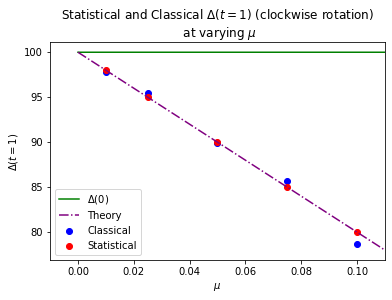

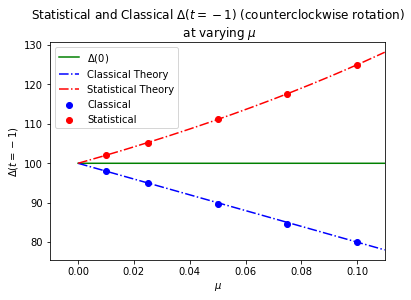

In [35]:
plt.figure('clockwise_comparison', figsize=(6,4))

x_arr = np.arange(0, 0.11, 0.0001)
delta_zero = 100*np.ones(np.size(x_arr))
both_theory_arr = (1 - 2*x_arr)*100

plt.plot(x_arr, delta_zero, 'green', label='$\Delta(0)$')

plt.scatter(mu_arr, classical_delta_c, color='b', label='Classical')
plt.scatter(mu_arr, statistical_delta_c, color='r', label='Statistical')

plt.plot(x_arr, both_theory_arr, color='purple', linestyle='dashdot', label='Theory')

plt.title('Statistical and Classical $\Delta(t=1)$ (clockwise rotation)\n at varying $\mu$')
plt.xlim(-0.01, 0.11)
plt.xlabel('$\mu$')
plt.ylabel('$\Delta(t=1)$')
plt.legend()


plt.figure('counterclockwise_comparison', figsize=(6,4))

classical_theory_arr = (1 - 2*x_arr)*100
statistical_theory_arr = ((1 - 2*x_arr)**(-1))*100

plt.plot(x_arr, delta_zero, 'green', label='$\Delta(0)$')

plt.scatter(mu_arr, classical_delta_cc, color='b', label='Classical')
plt.scatter(mu_arr, statistical_delta_cc, color='r', label='Statistical')

plt.plot(x_arr, classical_theory_arr, color='b', linestyle='dashdot', label='Classical Theory')
plt.plot(x_arr, statistical_theory_arr, color='r', linestyle='dashdot', label='Statistical Theory')

plt.title('Statistical and Classical $\Delta(t=-1)$ (counterclockwise rotation)\n at varying $\mu$')
plt.xlim(-0.01, 0.11)
plt.xlabel('$\mu$')
plt.ylabel('$\Delta(t=-1)$')
plt.legend()

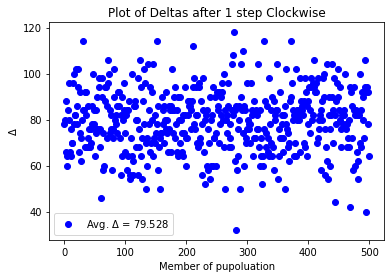

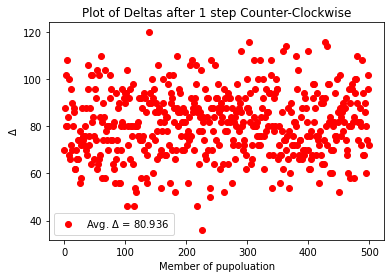

In [35]:
population = []
for i in range(500):
  population.append(KacRing(300, 200, 0.01))

c_deltas_arr = []
cc_deltas_arr = []

for ring in population:
  ring.step()
  c_deltas_arr.append(ring.meta['delta'])
  ring.step(clockwise=False)
  ring.step(clockwise=False)
  cc_deltas_arr.append(ring.meta['delta'])
  ring.step()


x_arr = [i for i in range(len(c_deltas_arr))]
plt.figure(0)
plt.scatter(x_arr, c_deltas_arr, color='b', 
            label=f'Avg. $\Delta$ = {np.mean(c_deltas_arr)}')
plt.xlabel('Member of pupoluation')
plt.ylabel('$\Delta$')
plt.title('Plot of Deltas after 1 step Clockwise')
plt.legend()

plt.figure(1)
plt.scatter(x_arr, cc_deltas_arr, color='r', 
            label=f'Avg. $\Delta$ = {np.mean(cc_deltas_arr)}')

plt.xlabel('Member of pupoluation')
plt.ylabel('$\Delta$')
plt.title('Plot of Deltas after 1 step Counter-Clockwise')
plt.legend()

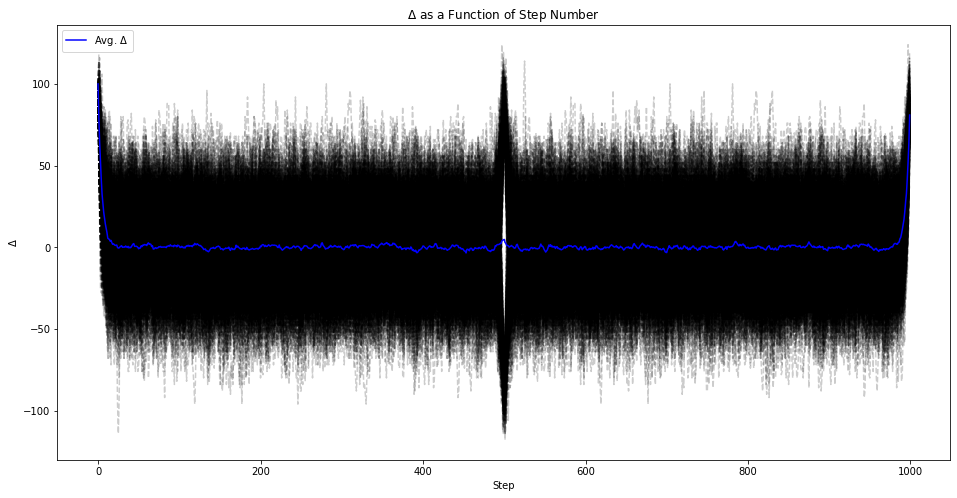

In [38]:
delta_arrs = []
x_arr = [i for i in range(population[0].meta['n_sites'] * 2)]

for ring in population:
  delta_arr = []

  for i in range(ring.meta['n_sites'] * 2):
    delta_arr.append(ring.meta['delta'])
    ring.step()
  
  delta_arrs.append(delta_arr)

plt.figure(2, figsize=(16, 8))
for i in range(len(delta_arrs)):
  plt.plot(x_arr, delta_arrs[i], 'k--', alpha=0.2)
plt.plot(x_arr, np.mean(delta_arrs, axis=0), 'b-', label='Avg. $\Delta$')
plt.xlabel('Step')
plt.ylabel('$\Delta$')
plt.title('$\Delta$ as a Function of Step Number')
plt.legend()